# Demonstrating the Theil Index of Inequality

This notebook provides an illustration of the pysal-inequality package and its implementation of Theil's entropy-based inequality index, along with spatially explicit enhancements of the index. The analysis focuses on Mexico’s regional income inequality over the period 1940-2000, utilizing PySAL's inequality module to measure and decompose inequality.
## Spatial Inequality in Mexico: 1940-2000

The data come from an early paper by Rey and Sastré-Gutiérrez (2010) and report per-capita gross regional product for the 32 Mexican States:

-------------------------

### Imports & Input Data

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-07-06T22:07:03.878754-04:00

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import libpysal
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

import inequality

%watermark -w
%watermark -iv

Watermark: 2.5.0

pandas    : 2.3.0
numpy     : 2.3.1
seaborn   : 0.13.2
libpysal  : 4.12.1
matplotlib: 3.10.3
geopandas : 1.1.1
inequality: 1.1.2.dev10+g423ae0e.d20250706



In [3]:
libpysal.examples.explain("mexico")

mexico

Decennial per capita incomes of Mexican states 1940-2000
--------------------------------------------------------

* mexico.csv: attribute data. (n=32, k=13)
* mexico.gal: spatial weights in GAL format.
* mexicojoin.shp: Polygon shapefile. (n=32)

Data used in Rey, S.J. and M.L. Sastre Gutierrez. (2010) "Interregional inequality dynamics in Mexico." Spatial Economic Analysis, 5: 277-298.



In [4]:
pth = libpysal.examples.get_path("mexicojoin.shp")
gdf = geopandas.read_file(pth)

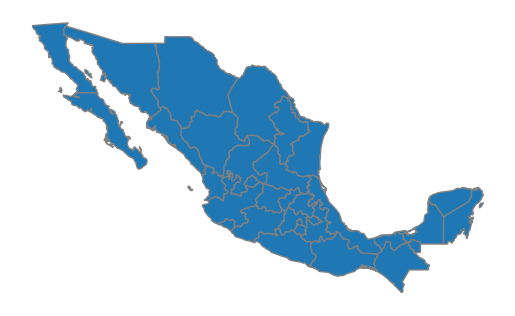

In [5]:
ax = gdf.plot(edgecolor="grey")
ax.set_axis_off()

In [6]:
gdf.head()

,POLY_ID,AREA,CODE,NAME,PERIMETER,ACRES,HECTARES,PCGDP1940,PCGDP1950,PCGDP1960,...,GR9000,LPCGDP40,LPCGDP50,LPCGDP60,LPCGDP70,LPCGDP80,LPCGDP90,LPCGDP00,TEST,geometry
0,1,7.252751e+10,MX02,Baja California Norte,2040312.385,1.792187e+07,7252751.376,22361.0,20977.0,17865.0,...,0.05,4.35,4.32,4.25,4.40,4.47,4.43,4.48,1.0,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,2,7.225988e+10,MX03,Baja California Sur,2912880.772,1.785573e+07,7225987.769,9573.0,16013.0,16707.0,...,0.00,3.98,4.20,4.22,4.39,4.46,4.41,4.42,2.0,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,3,2.731957e+10,MX18,Nayarit,1034770.341,6.750785e+06,2731956.859,4836.0,7515.0,7621.0,...,-0.05,3.68,3.88,3.88,4.04,4.13,4.11,4.06,3.0,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."
3,4,7.961008e+10,MX14,Jalisco,2324727.436,1.967200e+07,7961008.285,5309.0,8232.0,9953.0,...,0.03,3.73,3.92,4.00,4.21,4.32,4.30,4.33,4.0,"POLYGON ((-101.5249 21.85664, -101.5883 21.772..."
4,5,5.467030e+09,MX01,Aguascalientes,313895.530,1.350927e+06,546702.985,10384.0,6234.0,8714.0,...,0.13,4.02,3.79,3.94,4.21,4.32,4.32,4.44,5.0,"POLYGON ((-101.8462 22.01176, -101.9653 21.883..."


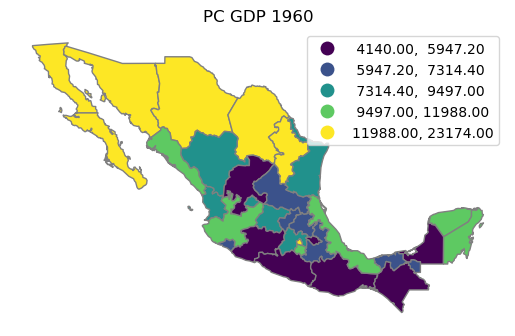

In [7]:
ax = gdf.plot(
    column="PCGDP1960", k=5, scheme="Quantiles", edgecolor="grey", legend=True
)
ax.set_axis_off()
ax.set_title("PC GDP 1960");

------------------------------------------------

### Classic Theil Coefficient

The departure point for the Theil inequality coefficient is to consider a set of $m$ areas, each having per-capita income $y_i$. Let $s_i = y_i / \sum_{i=1}^m y_i$ represent the "share" of area $i$'s income relative to overall income, where overall income is the sum of all per-capita incomes. This implies that $s_i \ge 0$ and $\sum_{i=1}^m s_i = 1$.

Were per-capita incomes equal across the areas, then $s_i = \frac{1}{m} \ \forall i = 1,\ldots,m.$
At the other end of the spectrum, one area would have all income, and per-capita income in the remainin areas would be 0, representing complete inequality.

Focusing on the per-capita income shares distribution, its entropy is:
$$
H(s) = \sum_{i=1}^m s_i \ln \frac{1}{s_i}
$$

This gives a measure of *income equality* with a maximum of $\ln(m)$, and a minimum of 0.



Theil's inequality coefficient is obtained by subtracting the entropy of the observed share distribution from its maximum:

$$
T = \ln m - H(s) = \sum_{i=1}^m s_i \ln (m s_i)
$$
This can be re-expressed using the per-capita incomes as:
$$
T = \sum_{i=1}^m \left ( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left [m \frac{y_i}{\sum_{i=1}^m y_i} \right ] \right ).
$$

Applying this to the case of Mexico, we have $m=32$ states, and for 1940 the Theil's $T$ is:


In [8]:
theil_1940 = inequality.theil.Theil(gdf["PCGDP1940"])
theil_1940.T

0.20894344230358594

--------------------------------------

### Theil Regional Inequality Decomposition
Like many of the popular inequality indices, Theil's $T$ does not take the spatial configuration of the data into account. However, early on, Theil (1967, p. 101) noted that the spatial dimension of inequality could be addressed by exploiting the additive decompositional property of $T$.

More specifically, if one could partition the areas into a finite set of $\omega$ multually exclusive and exhaustive regions, then the overall level of inequality can be decomposed into:

- inequality between regions
- inequality within regions

The formal decomposition is as follows:
$$
T = \sum_{i=1}^m \left ( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left [m \frac{y_i}{\sum_{i=1}^m y_i} \right ] \right ) = \left [ \sum_{g=1}^\omega s_g \ln \left ( \frac{m}{m_g} s_g  \right)  \right ]
+ \left [ \sum_{g=1}^\omega s_g \sum_{i \in g} s_{i,g} \ln \left( m_g s_{i,g} \right) \right ]
$$
where $s_g= \frac{\sum_{i \in g} y_i}{\sum_i y_i}$, and $s_{i,g} = \frac{y_i}{\sum_{i \in g} y_i}$.
The first term in the decomposition is the so-called *between-regions* inequality, while the second term is the *within-regions* inequality component.

PySAL implements this regional decomposition in the `TheilD` class:

In [9]:
inequality.theil.TheilD

inequality.theil.TheilD

To illustrate this decomposition, we can use the regionalization scheme suggested by Hanson (1996) for the study of the impacts of the North American Free Trade Agreement (NAFTA) on Mexico. This partion consists of five regions:

In [10]:
regimes = gdf["HANSON98"]

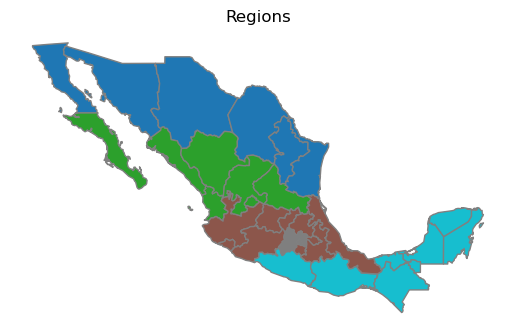

In [11]:
ax = gdf.plot(column="HANSON98", categorical=True, edgecolor="grey")
ax.set_title("Regions")
ax.set_axis_off()

In [12]:
numpy.random.seed(12345)
ts = inequality.theil.TheilD(gdf["PCGDP1940"], regimes)

In [13]:
ts.T

0.20894344230358594

In [14]:
ts.bg

array([0.0345889])

In [15]:
ts.wg

array([0.17435454])

A measure of *spatial polarization* is obtained as the ratio of the `bg` component to overall inequality `T`:


In [16]:
ts.bg[0] / ts.T

np.float64(0.16554192687439245)

In other words, inequality between the regions accounts for just over 16 percent of overall inequality between the states in Mexico in 1940.

This leads to a question of how to interpret this polarization measure. One way to answer this, is to compare this value against that obtained from a random distribution. That is, does the assignment of states to the regions actually matter?

### Inference on inequality decomposition

We address the inference question by randomly assigning states to the regions. This is done though a random permutation of the 32 states. We repeat this random permutation a large number of times, and for each random permutation we calculate the decomposition. Since the random permutations are the counterfactuals where state incomes were random in space, this gives us a distribution of the between group (region) component under the null.



In [17]:
numpy.random.seed(10)

In [18]:
ts = inequality.theil.TheilDSim(gdf["PCGDP1940"], regimes, permutations=999)

In [19]:
ts.bg_pvalue

array([0.392])

The p-value is a pseudo p-value obtained as the share of all realizations (including the observed realization) that generated `bg` values as large as the one observed. Since we asked for 999 permutations, our p-value indicates the level of spatial polarization in 1940 was not larger than what would be expect from a random spatial distribution of incomes across the partition. 

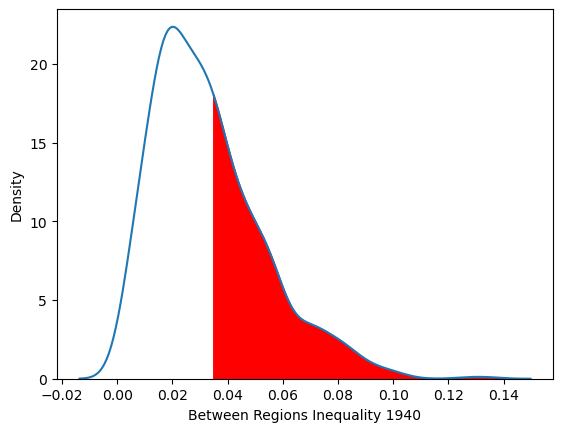

In [20]:
kdeplot = seaborn.kdeplot(ts.bg, fill=False, legend=False)
x_vals = kdeplot.lines[0].get_xdata()
y_vals = kdeplot.lines[0].get_ydata()
plt.fill_between(x_vals, y_vals, where=(x_vals > ts.bg[0]), color="red")
plt.xlabel("Between Regions Inequality 1940");

Repeating the decomposition for 1960 reveals a very different result regarding spatial polarization. Now the observed between-regions component is statistically significant as only 2 of the 999 random maps generated spatial polarization that was as extreme as what was actually observed.

In [21]:
ts = inequality.theil.TheilDSim(gdf["PCGDP1960"], regimes, permutations=999)

In [22]:
ts.bg_pvalue

array([0.003])

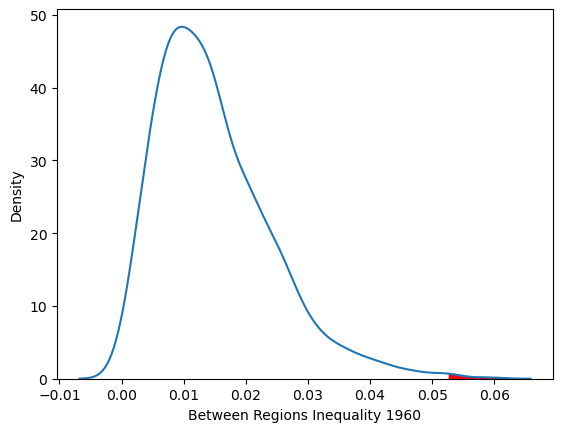

In [23]:
kdeplot = seaborn.kdeplot(ts.bg, fill=False, legend=False)
x_vals = kdeplot.lines[0].get_xdata()
y_vals = kdeplot.lines[0].get_ydata()
plt.fill_between(x_vals, y_vals, where=(x_vals > ts.bg[0]), color="red")
plt.xlabel("Between Regions Inequality 1960");

-----------------------

## Dynamics of Regional Inequality

The different results for 1940 and 1960 suggest the dynamics of overall regional inequality and spatial polarization need to be considered together.
We can carry out the regional decomposition for each decade and plot the resulting time series to provide insights into these dynamics:


In [24]:
decades = range(1940, 2010, 10)
numpy.random.seed(12345)

ts = [inequality.theil.Theil(gdf[f"PCGDP{decade}"]).T for decade in decades]
tsd = [
    inequality.theil.TheilDSim(gdf[f"PCGDP{decade}"], regimes, permutations=999)
    for decade in decades
]


p = numpy.array([(tsdi.bg_pvalue[0], tsdi.T, tsdi.results[0].bg[0]) for tsdi in tsd])

In [25]:
rdf = pandas.DataFrame(data=p, columns=["p-value", "Theil", "BG"])
rdf["BGshare"] = rdf.BG / rdf.Theil
rdf["Year"] = decades

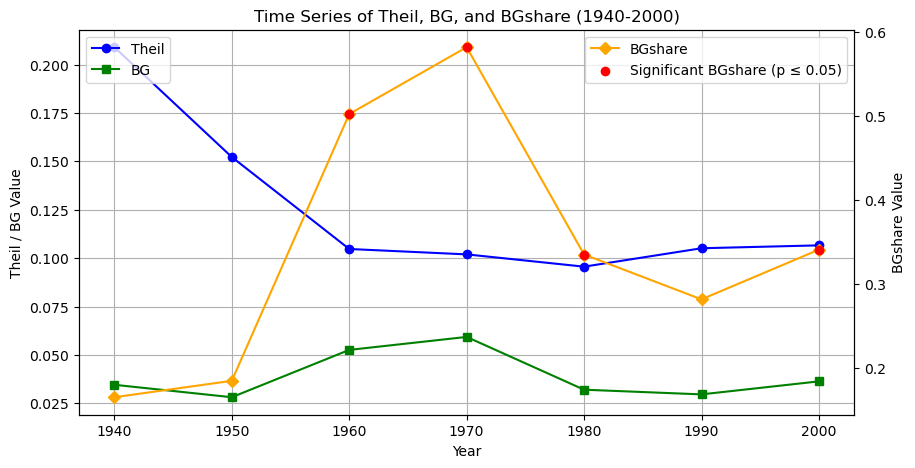

In [26]:
significant_points = rdf[rdf["p-value"] <= 0.05]
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(rdf["Year"], rdf["Theil"], marker="o", label="Theil", color="blue")
ax1.plot(rdf["Year"], rdf["BG"], marker="s", label="BG", color="green")
ax1.set_xlabel("Year")
ax1.set_ylabel("Theil / BG Value")
ax1.set_title("Time Series of Theil, BG, and BGshare (1940-2000)")
ax2 = ax1.twinx()
ax2.plot(rdf["Year"], rdf["BGshare"], marker="D", label="BGshare", color="orange")
ax2.scatter(
    significant_points["Year"],
    significant_points["BGshare"],
    color="red",
    label="Significant BGshare (p ≤ 0.05)",
    zorder=3,
)

ax2.set_ylabel("BGshare Value")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.grid(True)
plt.show()




The plot displays the evolution of three key indicators—**Theil, BG, and BGshare**—over time, with **BGshare** assigned a secondary Y-axis.
Overall inequality was highest in the initial decades, with a substantial decline from 1940 through 1960 followed by relative stability from 1960 forward.
In contrast, the between-regions inequality component is relatively more stable in the earlier decades and becomes more important in 1960 and 1970 where it accounts for over half of overall inequality, 50 and 58 percent respectively. In those two decades there is significant spatial polarization.
While the polarization peaks in 1970 and drops in subsequent decades, it remains significant in 1980 and 2000.


## References

- Hanson, Gordon H. U.S.-Mexico Integration and Regional Economies. Cambridge: National Bureau of Economic Research, 1996.
- Rey, Sergio J., and Myrna L Sastré-Gutiérrez. “Interregional Inequality Dynamics in Mexico.” Spatial Economic Analysis 5, no. 3 (2010): 277–98.
- Theil, Henri. Economics and Information Theory. Amsterdam: North Holland, 1967.


